In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing libraries

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()



#Importing Data
1. Importing the Twitter Sentiment dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [83]:
train_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentiment Analysis/SA Kaggle/twitter_sentiment_data.csv')

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [84]:
train_data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [91]:
train_data=train_data.replace(to_replace = -1, value =4)

In [92]:
train_data.head()

,sentiment,message,tweetid
0,4,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [93]:
def get_tweet(data):
  tweets = data["message"].tolist()
  labels = data["sentiment"].tolist()
  return tweets,labels  

In [94]:
tweets, labels=get_tweet(train_data)
tweets[0] , labels[0]

('@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom',
 4)

#Cleaning the *data*

##Lower Case

In [95]:
def lower_case(x):
    x = x.lower()
    return x


def lower_tweets(data):
  for i in range(len(data)):
    data[i]=lower_case(data[i])
  return data

In [96]:
lower_tweets=lower_tweets(tweets)
lower_tweets[0]

'@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom'

##Removing Unicode Characters

In [97]:
import re
def remove_unicode_haracters(text):
  text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
  return text


def rmv_unic(data):
  for i in range(len(data)):
    data[i]=remove_unicode_haracters(data[i])
  return data

In [98]:
rmv_unic_tweets=rmv_unic(lower_tweets)
rmv_unic_tweets[9]

'beforetheflood watch beforetheflood right here as leodicaprio travels the world to tackle climate change '

In [99]:
new_tweets=rmv_unic_tweets

#Tokenizer
##Tokenizing the tweets

In [100]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [101]:
tokenizer=Tokenizer(num_words=10000,oov_token='</UK')
tokenizer.fit_on_texts(new_tweets)
tokenizer.texts_to_sequences([new_tweets[0]])

[[1,
  2,
  3,
  6,
  58,
  764,
  1,
  34,
  21,
  66,
  9,
  10,
  39,
  4,
  123,
  1331,
  10,
  14,
  699,
  342,
  293,
  4,
  5423,
  3779]]

##Padding and Truncating Sequences
1. Checking length of the tweet
2. Creating padded sequences

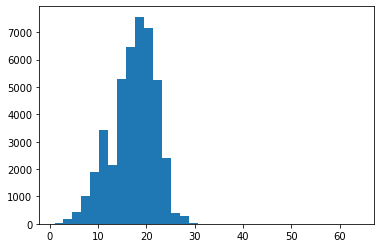

In [102]:
lenghts=[len(t.split(' '))for t in tweets]
plt.hist(lenghts,bins=len(set(lenghts)))
plt.show()

In [103]:
maxlen=23

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [104]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [105]:
padded_train_seq=get_sequences(tokenizer,new_tweets)
padded_train_seq[0]

array([   1,    2,    3,    6,   58,  764,    1,   34,   21,   66,    9,
         10,   39,    4,  123, 1331,   10,   14,  699,  342,  293,    4,
       5423], dtype=int32)

#Preparing the Labels
1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [106]:
classes=set(labels)
print(classes)

{0, 1, 2, 4}


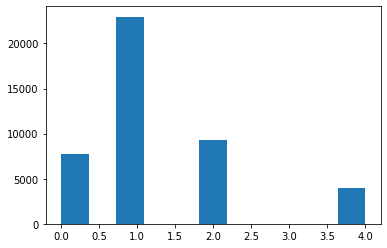

In [107]:
plt.hist(labels,bins=11)
plt.show()

In [109]:
class_to_index=dict({
    '0':'Neutral',
    '1':'Pro',
    '2':'News',
    '4':'Anti'
})
index_to_class=dict((v,k)for k,v in class_to_index.items())

In [110]:
class_to_index

{'0': 'Neutral', '1': 'Pro', '2': 'News', '4': 'Anti'}

In [111]:
index_to_class

{'Anti': '4', 'Neutral': '0', 'News': '2', 'Pro': '1'}

In [112]:
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [113]:
train_labels=labels
print(train_labels[0])

4


#Creating the Model
1. Creating the model
2. Compiling the model

In [139]:
from tensorflow.keras.optimizers import Adam

##Hyperparameter Tuning

In [140]:
epochs=10
learning_rate = 0.1
decay_rate = learning_rate / epochs
Adam = Adam(lr=learning_rate, decay=decay_rate)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [141]:
model=tf.keras.models.Sequential([ 
       tf.keras.layers.Embedding(10000,64,input_length=maxlen),    
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
       tf.keras.layers.Dense(6,activation='softmax')                      
                                 
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [142]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 23, 64)            640000    
                                                                 
 bidirectional_16 (Bidirecti  (None, 23, 40)           13600     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 6)                 246       
                                                                 
Total params: 663,606
Trainable params: 663,606
Non-trainable params: 0
_________________________________________________________________


#Training the Model
1. Preparing a validation set
2. Training the model

In [143]:
val_tweets,val_labels=new_tweets,labels
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=val_labels
new_tweets[0],val_labels[0]

('tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom',
 4)

In [144]:
val_labels = np.asarray(val_labels)
train_labels = np.asarray(train_labels)

In [145]:
h=model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)]
)

Epoch 1/10
1374/1374 [==============================] - 76s 49ms/step - loss: 0.7956 - accuracy: 0.6861 - val_loss: 0.5438 - val_accuracy: 0.8041
Epoch 2/10
1374/1374 [==============================] - 65s 47ms/step - loss: 0.5288 - accuracy: 0.7956 - val_loss: 0.4259 - val_accuracy: 0.8293
Epoch 3/10
1374/1374 [==============================] - 65s 48ms/step - loss: 0.4287 - accuracy: 0.8371 - val_loss: 0.3132 - val_accuracy: 0.8936
Epoch 4/10
1374/1374 [==============================] - 63s 46ms/step - loss: 0.3550 - accuracy: 0.8657 - val_loss: 0.2605 - val_accuracy: 0.9137
Epoch 5/10
1374/1374 [==============================] - 66s 48ms/step - loss: 0.2893 - accuracy: 0.8932 - val_loss: 0.2132 - val_accuracy: 0.9272
Epoch 6/10
1374/1374 [==============================] - 64s 46ms/step - loss: 0.2381 - accuracy: 0.9139 - val_loss: 0.1777 - val_accuracy: 0.9401
Epoch 7/10
1374/1374 [==============================] - 66s 48ms/step - loss: 0.1980 - accuracy: 0.9288 - val_loss: 0.1390 -

#Evaluating the Model
1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

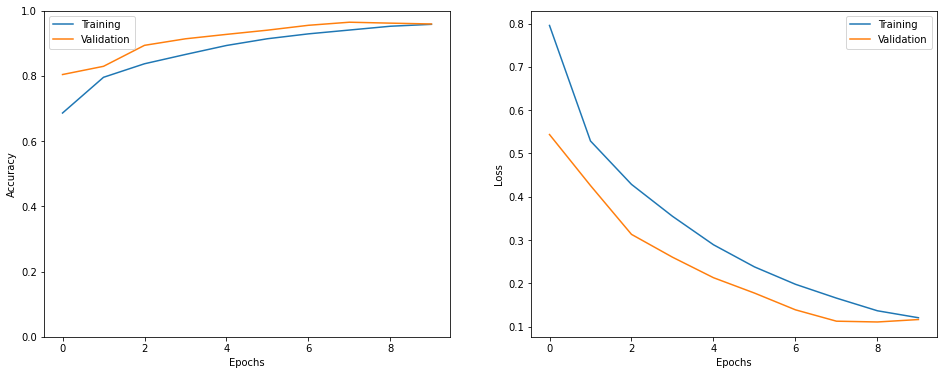

In [146]:
show_history(h)

##Creating Test Data

In [153]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=25)

In [154]:
test_data.head()

,sentiment,message,tweetid
9392,0,"the sun is shining, global warming has stopped...",809120277003202560
3540,1,RT @1followernodad: parent: I'd do anything fo...,796850103638257664
42019,1,Climate change visualized \nhttps://t.co/T72p...,737025950551035904
11679,1,RT @k_leen022: let's just keep pretending glob...,822858994507194368
2815,1,RT @BernieSanders: #ImVotingBecause the future...,796371385501229056


In [158]:
test_tweets,test_labels=get_tweet(test_data)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=test_labels

In [159]:
test_tweets[0],test_labels[0]

("the sun is shining, global warming has stopped, I suddenly have straight A's, my skin is clea- https://t.co/O56WL793ix",
 0)

In [160]:
test_seq.shape

(8789, 23)

In [161]:
test_labels = np.asarray(test_labels)

In [162]:
_=model.evaluate(test_seq,test_labels)

275/275 [==============================] - 2s 9ms/step - loss: 0.7757 - accuracy: 0.8172


In [163]:
i=random.randint(0,len(test_labels)-1)

print('Sentence:',test_tweets[i])
print('Emotions',test_labels[i])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=np.argmax(p).astype('uint8')

print('Predicted Emotion:',pred_class)
class_to_index

Sentence: RT @BernieSanders: #ImVotingBecause the future of the planet is at stake. Hillary Clinton will combat climate change. Donald Trump thinks iÃ¢â‚¬Â¦
Emotions 1
Predicted Emotion: 1


{'0': 'Neutral', '1': 'Pro', '2': 'News', '4': 'Anti'}

In [168]:
preds=model.predict(test_seq)
preds=np.argmax(preds,axis=1)

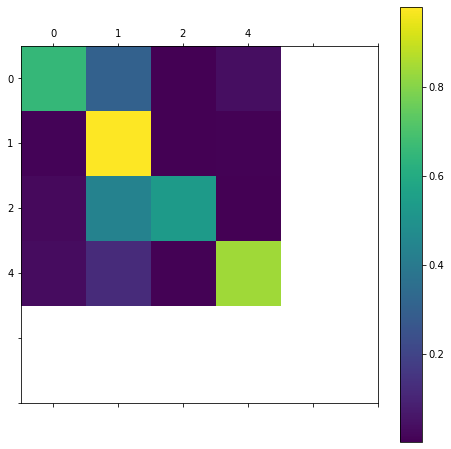

In [169]:
show_confusion_matrix(test_labels , preds , list(classes))